# Wave freqeuncy spectrum for a single grid cell
Frequency: [Starting here](https://wikiwaves.org/Ocean-Wave_Spectra) <br>
Direction: Young (1999) Section 5.5

In [240]:
# grab real world data 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset("/Users/alison/Documents/DPhil/data/era5/wind_data/bangladesh_2021.nc")
df = ds.to_dataframe().reset_index()
df['speed'] = np.sqrt(df['u10']**2 + df['v10']**2)
df['direction'] = np.arctan(df['v10'] / df['u10']) # East is 0 degrees [radians]

idxmax = df['speed'].idxmax()
U10 = df.loc[idxmax, :]['speed']
θ = df.loc[idxmax, :]['direction']
θm = lambda f: θ # constant direction across frequencies

# Make frequency spectrum for grid cell

In [246]:
# set up grid values
nfreqs = 100
ndirs = 200

freqs = np.linspace(0.01, 0.3, nfreqs)
thetas = np.linspace(-np.pi, np.pi, ndirs) # always orient so 0 degrees points to coastline

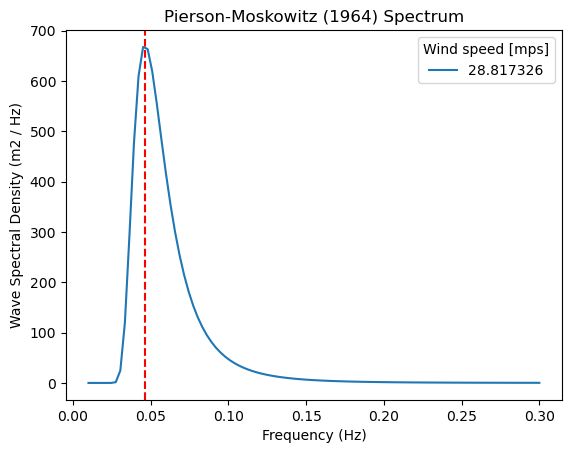

In [247]:
def drag_coeff_swan(U10, Uref=31.5):
    """SWAN documentation."""
    U_ = U10 / Uref
    Cd = (0.55 + 2.97 * U_ - 1.49 * U_**2)
    return Cd

def U_friction(U10):
    """SWAN documentation."""
    Cd = drag_coeff_swan(U10)
    U_friction = np.sqrt(Cd * U10**2)
    return U_friction


def peak_frequency_pm(U10, g=9.81):
    """Returns angular frequency σ.
    
    https://wikiwaves.org/Ocean-Wave_Spectra"""
    U195 = 1.026 * U10 
    σpm = (0.8777 * g) / U195
    return σpm

def spectrum_pm(f, U10=20, α=8.1e-3, β=0.74, g=9.81, radians=False):
    """Pierson and Moskovitz spectrum.
    https://wikiwaves.org/Ocean-Wave_Spectra
    """
    const = 1 if radians else 2 * np.pi
    ω = const * f
    U195 = 1.026 * U10 # assuming drag coefficient of 1.3e-3
    ω0 = g / U195
    S = ((α * g**2) / ω**5) * np.exp(-β * (ω0 / ω)**4)
    return const * S

fig, ax = plt.subplots()
Sf = spectrum_pm(freqs, U10)
ax.plot(freqs, Sf, label=U10)
ax.legend(loc='best', title='Wind speed [mps]');
ax.set_title('Pierson-Moskowitz (1964) Spectrum');
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Wave Spectral Density (m2 / Hz)');

fp = peak_frequency_pm(U10) / (2 * np.pi)
ax.axvline(fp, color='red', linestyle='dashed')

# Directional spreading
### Young (1999) §4.4.2.3 and §5.5
This directional spreading is often represented in terms of parametric models such as the $\cos^{2s}\theta/2$ model **(Mitsuyasu et al, 1975)**, where $\theta$ is the angle of wave propagation measured relative to the wind direction.  Such a model predicts that the directional spectrum is a maximum in the wind direction and gradually decreases as the angle to the wind direction increases [see Section (5.5)]. Indeed, this model predicts that a small amount of wave energy propagates at angles greater than 90° to the wind.


100 200
(200, 100)


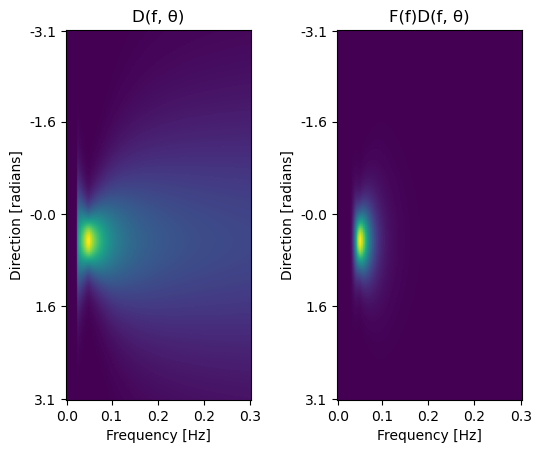

In [269]:
def directional_spread(θ, θm, f, fp):
    """Young (1990): Donelan et al. (1985) and Banner (1990)"""
    def βs(f, fp):
        βs = np.zeros(len(f))
        βs = np.where((0.56 <= f / fp) & (f / fp < 0.95), 2.61 * (f / fp)**1.3, βs)
        βs = np.where((0.95 <= f / fp) & (f / fp < 1.6), 2.28 * (f / fp)**(-1.3), βs)
        βs = np.where((1.6 <= f / fp), 10**(-0.4 + 0.8393 * np.exp(-0.567 * np.log((f / fp)**2))), βs)
        return βs
    
    βs = βs(f, fp)
    D =  0.5 * βs * (1 / np.cosh(np.outer((θ - θm(f)), βs)))**2
    return D

D = directional_spread(thetas, θm, freqs, fp)
print(nfreqs, ndirs)
print(D.shape)

fig, axs = plt.subplots(1, 2)
ax = axs[0]
ax.imshow(D)
xticks = np.linspace(0, nfreqs - 1, 5, dtype='int')
yticks = np.linspace(0, ndirs - 1, 5, dtype='int')
xticklabels = [f"{x:.1f}" for x in freqs[xticks]]
yticklabels = [f"{x:.1f}" for x in thetas[yticks]]
ax.set_xticks(xticks, labels=xticklabels);
ax.set_yticks(yticks, labels=yticklabels);
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Direction [radians]");
ax.set_title('D(f, θ)');

ax = axs[1]
ax.imshow(Sf * D)
xticks = np.linspace(0, nfreqs - 1, 5, dtype='int')
yticks = np.linspace(0, ndirs - 1, 5, dtype='int')
xticklabels = [f"{x:.1f}" for x in freqs[xticks]]
yticklabels = [f"{x:.1f}" for x in thetas[yticks]]
ax.set_xticks(xticks, labels=xticklabels);
ax.set_yticks(yticks, labels=yticklabels);
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Direction [radians]");
ax.set_title('F(f)D(f, θ)');

# Polar heatmap

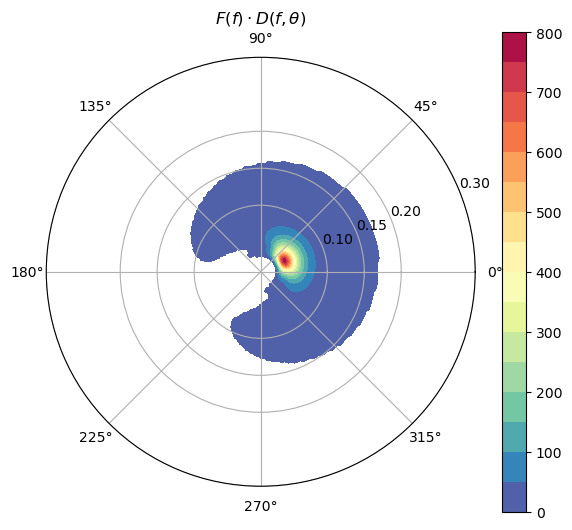

In [281]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

gs=gridspec.GridSpec(1,1)
gs.update(wspace=0.205, hspace=0.105) 
fig=plt.figure(figsize=(500/72.27,450/72.27))

X = freqs
Y = thetas
r, theta = np.meshgrid(X, Y)

Z = Sf * D
Z = np.where(Z < 1, np.nan, Z)

ax=fig.add_subplot(gs[0,0], projection='polar')
im = cax=ax.contourf(theta, r, Z, ntheta, cmap='Spectral_r')

ax.set_yticks([0.1, 0.15, 0.2, 0.3])
ax.tick_params(colors='black', axis="y", which='both')
ax.set_title(r"$F(f)\cdot D(f,\theta)$");
plt.colorbar(im)

# Numerical solutions in spectral space

In [276]:
N = Sf * D
N.sum()

234336.32468256666

In [80]:
spectrum_pm(sigmas).shape

(100,)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()